## Setup and Installation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install dash
!pip install rasterio
!pip install dash dash-bootstrap-components plotly pillow pandas


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 14.0 MB/s eta 0:00:00
  Attempting uninstall: Werkzeug
    Found existing installation: Werkzeug 3.1.3
    Uninstalling Werkzeug-3.1.3:
      Successfully uninstalled Werkzeug-3.1.3
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 61.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.5/222.5 kB 4.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
import glob
import tensorflow as tf
import cv2
import dash
import base64
import os
import io
import rasterio
from dash import dcc, html, Input, Output
import dash_bootstrap_components as dbc
import pandas as pd
from PIL import Image
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from collections import Counter


## Paths

In [ ]:
# Pfade zu den Daten
raster_path = "/content/drive/MyDrive/GroundTruthData/RasterData"  # Ordner mit Originalbildern (TIFFs)
mask_path = "/content/drive/MyDrive/GroundTruthData/SegmentationMasks"  # Masken (PNGs)
labelmap_path = "/content/drive/MyDrive/GroundTruthData/labelmap.txt"  # Labelmap
projects_biovalues_df = pd.read_csv('/content/drive/MyDrive/Projects_BioValues.csv')


## Bildnamen

In [ ]:
# Liste der Bildnamen im Verzeichnis ausgeben
image_files = [file for file in os.listdir(raster_path) if os.path.isfile(os.path.join(raster_path, file))]

image_files

['Parzelle_HG7626_2306.tif',
 'Parzelle_OB3455_2308.tif',
 'Parzelle_AF2399_2207.tif',
 'Parzelle_WO1900_2707.tif',
 'Parzelle_WI3878_2609.tif',
 'Parzelle_HG7909_2306.tif',
 'Parzelle_WO4730_2707.tif',
 'Parzelle_SE6813_2108.tif',
 'Parzelle_5789_CH989587617794_2005.tif',
 'Parzelle_1324_CH818970287742_3204.tif',
 'Parzelle_1575_CH407786929139_2010.tif',
 'Parzelle_BA7000_CH379677787604_2519.tif',
 'Parzelle_2081_CH127776678553_1704.tif',
 'Parzelle_5950_CH250808770570_1909.tif',
 'Parzelle_4164_CH849650779711_3313.tif',
 'Parzelle_7885_CH207708067615_3514.tif',
 'Parzelle_473_CH127791864892_3220.tif',
 'Parzelle_1375_CH827776993164_1007.tif',
 'Parzelle_3048_CH907710844145_3014.tif',
 'Parzelle_SE6637_2107.tif',
 'Parzelle_WE13005_WE13012_merged.tif']

## Analyse Klassenverteilung Masken

In [ ]:
# Labelmap einlesen
labelmap = {}
colors = {}
with open(labelmap_path, "r") as file:
    for line in file:
        if not line.startswith("#") and line.strip():  # Kommentare ignorieren
            label, color_rgb, *_ = line.split(":")
            r, g, b = map(int, color_rgb.split(","))
            labelmap[(r, g, b)] = label
            colors[label] = f"rgb({r},{g},{b})"

Klassenverteilung pro Bild:
Parzelle_OB3455_2308.png: {'background': 132775, 'Vegetationsfläche': 115715, 'Vegetationsfläche mit Bodenanschluss': 217996, 'Durchlässige Belagsfläche': 28441, 'Gebäude': 117311, 'Versiegelte Belagsfläche': 22661}
Parzelle_HG7909_2306.png: {'background': 355982, 'Versiegelte Belagsfläche': 95663, 'Vegetationsfläche': 46901, 'Gebäude': 177555, 'Vegetationsfläche mit Bodenanschluss': 50687, 'Teilversiegelte Belagsfläche': 1240}
Parzelle_WO1900_2707.png: {'background': 28846, 'Vegetationsfläche mit Bodenanschluss': 43304, 'Durchlässige Belagsfläche': 29204, 'Versiegelte Belagsfläche': 4513, 'Gebäude': 106929}
Parzelle_SE6637_2107.png: {'background': 313803, 'Versiegelte Belagsfläche': 251461, 'Gebäude': 1265630, 'Durchlässige Belagsfläche': 736565, 'Vegetationsfläche': 227541}
Parzelle_HG7626_2306.png: {'background': 1298181, 'Vegetationsfläche': 567731, 'Versiegelte Belagsfläche': 475177, 'Vegetationsfläche mit Bodenanschluss': 400904, 'Teilversiegelte Belag

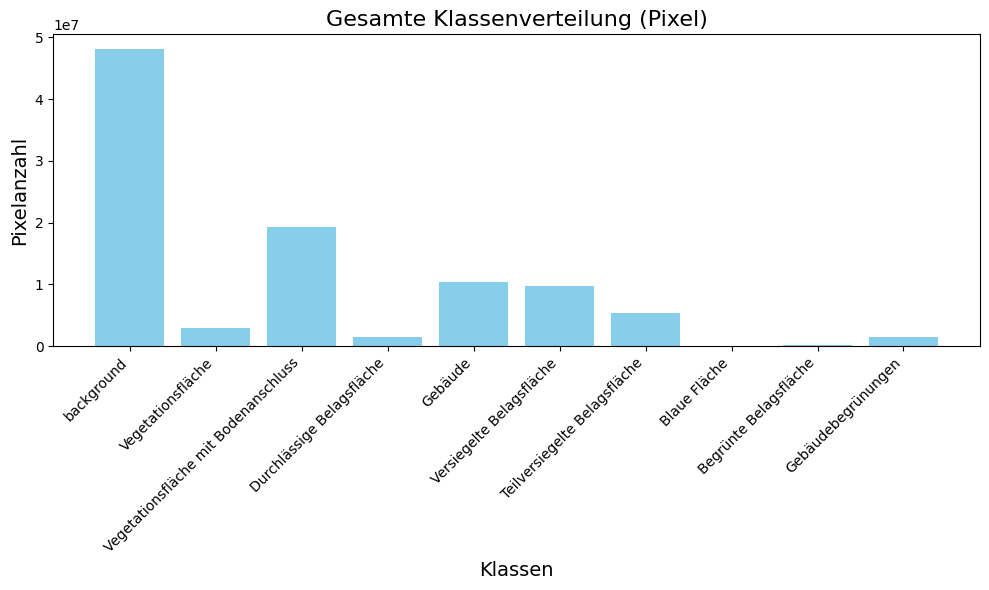

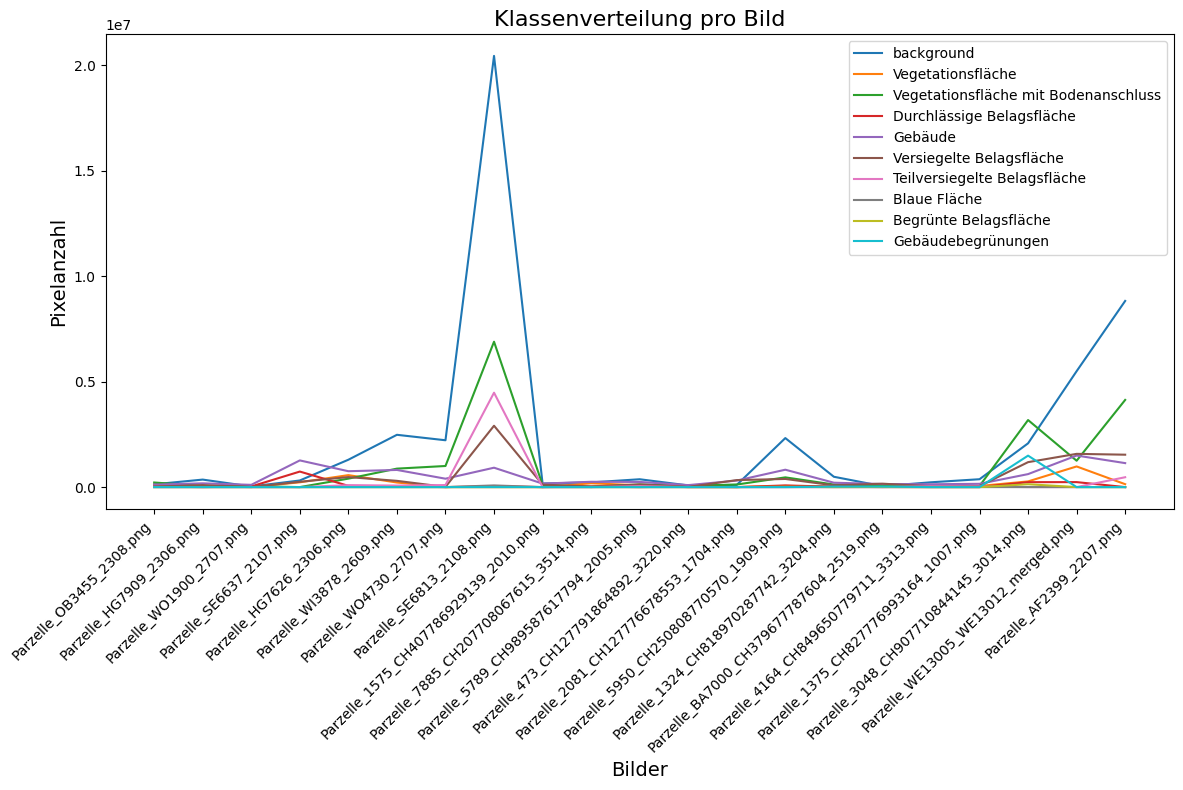

In [ ]:
# Klassen analysieren
def analyze_image_classes(mask_folder, labelmap):
    class_counts_per_image = {}
    overall_class_counts = Counter()

    for mask_file in os.listdir(mask_folder):
        mask_path = os.path.join(mask_folder, mask_file)
        mask = np.array(Image.open(mask_path))

        # Pixel pro Klasse zählen
        class_counts = Counter(tuple(pixel) for row in mask for pixel in row)
        mapped_counts = {labelmap.get(color, "Unknown"): count for color, count in class_counts.items()}

        # Für jedes Bild speichern
        class_counts_per_image[mask_file] = mapped_counts

        # Gesamtverteilung aktualisieren
        for label, count in mapped_counts.items():
            overall_class_counts[label] += count

    return class_counts_per_image, overall_class_counts

# Analyse durchführen
class_counts_per_image, overall_class_counts = analyze_image_classes(mask_path, labelmap)

# Ergebnisse ausgeben
print("Klassenverteilung pro Bild:")
for image, counts in class_counts_per_image.items():
    print(f"{image}: {counts}")

print("\nGesamte Klassenverteilung:")
print(overall_class_counts)

# Daten für Visualisierung vorbereiten
class_distribution_df = pd.DataFrame.from_dict(class_counts_per_image, orient='index').fillna(0).astype(int)

# Visualisierung
import matplotlib.pyplot as plt

# Gesamte Verteilung
plt.figure(figsize=(10, 6))
overall_labels = list(overall_class_counts.keys())
overall_counts = list(overall_class_counts.values())
plt.bar(overall_labels, overall_counts, color='skyblue')
plt.title("Gesamte Klassenverteilung (Pixel)", fontsize=16)
plt.xlabel("Klassen", fontsize=14)
plt.ylabel("Pixelanzahl", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Verteilung pro Bild
plt.figure(figsize=(12, 8))
for label in class_distribution_df.columns:
    plt.plot(class_distribution_df.index, class_distribution_df[label], label=label)
plt.title("Klassenverteilung pro Bild", fontsize=16)
plt.xlabel("Bilder", fontsize=14)
plt.ylabel("Pixelanzahl", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Funktion zur Analyse der Masken
def analyze_masks(mask_path, labelmap):
    label_counts = Counter()  # Zum Zählen der Labels
    total_pixels = 0  # Gesamtanzahl der Pixel

    for mask_file in os.listdir(mask_path):
        if mask_file.endswith(".png"):  # Nur PNG-Masken analysieren
            mask = np.array(Image.open(os.path.join(mask_path, mask_file)))

            # Mapping der RGB-Werte zu Labels
            for rgb, label in labelmap.items():
                match = (mask == rgb).all(axis=-1)  # Pixel, die zu diesem Label passen
                label_counts[label] += np.sum(match)

            # Gesamtpixelanzahl
            total_pixels += mask.shape[0] * mask.shape[1]

    return label_counts, total_pixels


# Analyse durchführen
label_counts, total_pixels = analyze_masks(mask_path, labelmap)

# Prozentuale Verteilung berechnen
label_distribution = {label: count / total_pixels * 100 for label, count in label_counts.items()}

# DataFrame für die Übersicht erstellen
df = pd.DataFrame({
    "Label": list(label_counts.keys()),
    "Pixel Count": list(label_counts.values()),
    "Percentage (%)": list(label_distribution.values()),
    "Color": [colors[label] for label in label_counts.keys()]
})

# Ergebnisse anzeigen
print(df)



                                  Label  Pixel Count  Percentage (%)  \
0                 Begrünte Belagsfläche       161784        0.163334   
1                          Blaue Fläche        79066        0.079824   
2             Durchlässige Belagsfläche      1560545        1.575501   
3                               Gebäude     10336001       10.435057   
4                    Gebäudebegrünungen      1538033        1.552773   
5          Teilversiegelte Belagsfläche      5307943        5.358812   
6                     Vegetationsfläche      2979002        3.007552   
7  Vegetationsfläche mit Bodenanschluss     19263351       19.447963   
8              Versiegelte Belagsfläche      9674980        9.767701   
9                            background     48150033       48.611483   

             Color  
0   rgb(124,252,0)  
1  rgb(42,125,209)  
2  rgb(184,134,11)  
3     rgb(139,0,0)  
4   rgb(34,139,34)  
5   rgb(255,140,0)  
6     rgb(0,100,0)  
7   rgb(50,205,50)  
8   rgb(255,215,0)

## Berechnung qm Raster und Masken

This Python code creates a Dash web application for validating segmented masks against raster images. It visually compares original images with their respective segmentation masks and calculates relevant statistics for further analysis.

In [ ]:
output_csv_path = "/content/drive/MyDrive/Area_Analysis_Consolidated.csv"

In [ ]:
# Labelmap einlesen
labelmap = {}
with open(labelmap_path, "r") as file:
    for line in file:
        if not line.startswith("#") and line.strip():
            label, color_rgb, *_ = line.split(":")
            labelmap[tuple(map(int, color_rgb.split(",")))] = label

# Hauptfunktion für Analyse
def analyze_parzellen(parzellen, labelmap, mask_path, raster_path):
    results = []

    for parzelle in parzellen:
        try:
            # Dateien laden
            raster_file = os.path.join(raster_path, f"{parzelle}.tif")
            mask_file = os.path.join(mask_path, f"{parzelle}.png")

            with rasterio.open(raster_file) as src:
                pixel_size = src.res[0] * src.res[1]  # Pixelgröße in Quadratmetern

            mask_image = np.array(Image.open(mask_file))

            # Grundstücksfläche berechnen (alle Pixel außer "background")
            unique_colors, counts = np.unique(
                mask_image.reshape(-1, mask_image.shape[-1]), axis=0, return_counts=True
            )
            total_area_m2 = 0
            area_data = {"Rasterdatei": parzelle}

            for color, count in zip(unique_colors, counts):
                color_tuple = tuple(color)
                if color_tuple in labelmap:
                    label = labelmap[color_tuple]
                    area_m2 = count * pixel_size
                    area_data[label] = area_m2

                    # Hintergrund nicht zur Grundstücksfläche zählen
                    if label != "background":
                        total_area_m2 += area_m2

            area_data["Grundstücksfläche (m²)"] = total_area_m2
            results.append(area_data)

        except Exception as e:
            print(f"Fehler bei {parzelle}: {str(e)}")

    # DataFrame erstellen
    return pd.DataFrame(results)

# Liste der Parzellen
parzellen = [f.split(".")[0] for f in os.listdir(mask_path) if f.endswith(".png")]

# Analyse durchführen und CSV speichern
masks_df = analyze_parzellen(parzellen, labelmap, mask_path, raster_path)
masks_df.to_csv(output_csv_path, index=False)
print(f"CSV-Datei gespeichert: {output_csv_path}")

# Dash-App erstellen
app = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

# App-Layout
app.layout = dbc.Container([
    html.H1("Parzellenanalyse", style={"text-align": "center", "margin-bottom": "20px"}),

    # Dropdown zur Auswahl der Parzelle
    dcc.Dropdown(
        id="parzelle-dropdown",
        options=[{"label": parzelle, "value": parzelle} for parzelle in parzellen],
        placeholder="Wähle eine Parzelle aus",
        style={"margin-bottom": "20px"}
    ),

    # Anzeigen des Originalfotos und der Maske
    dbc.Row([
        dbc.Col(html.Div(id="original-image"), width=6),
        dbc.Col(html.Div(id="mask-image"), width=6),
    ]),

    # Legende mit Quadratmetern und prozentualem Anteil
    html.Div(id="legend", style={"margin-top": "30px"})
])

@app.callback(
    [Output("original-image", "children"),
     Output("mask-image", "children"),
     Output("legend", "children")],
    [Input("parzelle-dropdown", "value")]
)
def update_parzelle(selected_parzelle):
    if not selected_parzelle:
        return None, None, "Bitte wähle eine Parzelle aus."

    try:
        # Dateien laden
        raster_file = os.path.join(raster_path, f"{selected_parzelle}.tif")
        mask_file = os.path.join(mask_path, f"{selected_parzelle}.png")

        with rasterio.open(raster_file) as src:
            original_image = np.array(src.read([1, 2, 3]).transpose(1, 2, 0))  # RGB-Bands
            pixel_size = src.res[0] * src.res[1]

        mask_image = np.array(Image.open(mask_file))

        # Analyse der Maske
        unique_colors, counts = np.unique(mask_image.reshape(-1, mask_image.shape[-1]), axis=0, return_counts=True)
        total_pixels = mask_image.shape[0] * mask_image.shape[1]
        legend_data = []

        for color, count in zip(unique_colors, counts):
            color_tuple = tuple(color)
            if color_tuple in labelmap:
                label = labelmap[color_tuple]
                area_m2 = count * pixel_size
                legend_data.append({
                    "Label": label,
                    "Color": color_tuple,
                    "Pixel Count": count,
                    "Area (m²)": area_m2,
                    "Area (%)": (count / total_pixels) * 100
                })

        # Grundstücksfläche hinzufügen (ohne "background")
        total_property_area = sum(entry["Area (m²)"] for entry in legend_data if entry["Label"] != "background")
        legend_data.append({
            "Label": "Grundstücksfläche",
            "Color": (0, 0, 0),
            "Pixel Count": "N/A",
            "Area (m²)": total_property_area,
            "Area (%)": 100
        })

        # DataFrame für die Legende erstellen
        legend_df = pd.DataFrame(legend_data)

        # Legende mit Farbfeldern erstellen
        legend_table = html.Table([
            html.Thead(html.Tr([html.Th("Label"), html.Th("Color"), html.Th("Area (m²)"), html.Th("Area (%)")])),

            html.Tbody([
                html.Tr([
                    html.Td(row["Label"]),
                    html.Td(html.Div(style={
                        "background-color": f"rgb{row['Color']}",
                        "width": "20px",
                        "height": "20px",
                        "border": "1px solid black"
                    })),
                    html.Td(f"{row['Area (m²)']:.2f}"),
                    html.Td(f"{row['Area (%)']:.2f}%")
                ])
                for _, row in legend_df.iterrows()
            ])
        ], style={"margin-top": "20px", "border": "1px solid black", "width": "100%"})

        # Originalfoto und Maske als Graph
        original_fig = px.imshow(original_image, title="Originalfoto")
        mask_fig = px.imshow(mask_image, title="Maske")

        return (
            dcc.Graph(figure=original_fig),
            dcc.Graph(figure=mask_fig),
            legend_table
        )

    except Exception as e:
        print(f"Fehler: {str(e)}")
        return None, None, f"Fehler: {str(e)}"

# App ausführen
if __name__ == "__main__":
    app.run_server(debug=True)


CSV-Datei gespeichert: /content/drive/MyDrive/Area_Analysis_Consolidated.csv


<IPython.core.display.Javascript object>

In [ ]:
# CSV-Datei laden
masks_df = pd.read_csv(output_csv_path)

# DataFrame anzeigen
print(masks_df.head())


            Rasterdatei  background  Vegetationsfläche  \
0  Parzelle_OB3455_2308    331.9375           289.2875   
1  Parzelle_HG7909_2306    889.9550           117.2525   
2  Parzelle_WO1900_2707     72.1150                NaN   
3  Parzelle_SE6637_2107    784.5075           568.8525   
4  Parzelle_HG7626_2306   3245.4525          1419.3275   

   Vegetationsfläche mit Bodenanschluss    Gebäude  Durchlässige Belagsfläche  \
0                              544.9900   293.2775                    71.1025   
1                              126.7175   443.8875                        NaN   
2                              108.2600   267.3225                    73.0100   
3                                   NaN  3164.0750                  1841.4125   
4                             1002.2600  1882.6475                   147.6350   

   Versiegelte Belagsfläche  Grundstücksfläche (m²)  \
0                   56.6525               1255.3100   
1                  239.1575                930.1150   

## Projektinfos BioValues

In [ ]:
print(projects_biovalues_df.head())

      ID                   Titel           Firma Parzellen-Nr      EGRIS_EGRI  \
0  12680                ZKB Wald  Kompass B GmbH          473  CH127791864892   
1  12656  ZKB Affoltern am Albis  Kompass B GmbH         1324  CH818970287742   
2  12684             ZKB Eglisau  Kompass B GmbH         1375  CH827776993164   
3  12658         ZKB Bassersdorf  Kompass B GmbH         1575  CH407786929139   
4  12662           ZKB Dielsdorf  Kompass B GmbH         2081  CH127776678553   

  Validierungsprojekte                        Rasterdatei  \
0   Validierungsobjekt   Parzelle_473_CH127791864892_3220   
1   Validierungsobjekt  Parzelle_1324_CH818970287742_3204   
2   Validierungsobjekt  Parzelle_1375_CH827776993164_1007   
3   Validierungsobjekt  Parzelle_1575_CH407786929139_2010   
4   Validierungsobjekt  Parzelle_2081_CH127776678553_1704   

                   Art des Projektes                          Nutzungsart  \
0  Umgebungaufwertung (ohne Gebäude)  Gewerbe (Handel & Dienstleistun

In [ ]:
# Spaltennamen ausgeben
column_names_csv = projects_biovalues_df.columns.tolist()
print(column_names_csv)


['ID', 'Titel', 'Firma', 'Parzellen-Nr', 'EGRIS_EGRI', 'Validierungsprojekte', 'Rasterdatei', 'Art des Projektes', 'Nutzungsart', 'Dichte', 'Check Excel und Google Earth', 'BFF Grundstückfläche in m2', 'BFF Gebäudegrundfläche in m2', 'BFF Versiegelte Belagsflächen', 'BFF Teilversiegelte Belagsflächen', 'BFF Durchlässige Belagsflächen', 'BFF Begrünte Belagsflächen', 'BFF Vegetationsfläche mit Bodenanschluss', 'BFF Unterbaute Vegetationsfläche mit geringer Substratmächtigkeit (20-40 cm)', 'BFF Unterbaute Vegetationsfläche mit mittlerer Substratmächtigkeit (41-80 cm)', 'BFF Unterbaute Vegetationsfläche mit hoher Substratmächtigkeit (81-150 cm)', 'BFF Unterbaute Vegetationsfläche mit sehr hoher Substratmächtigkeit (>150 cm)', 'BFF Versickerungsfläche', 'BFF Regenwassergespeiste Wasserfläche', 'BFF Dachbegrünung: Extensivbegrünung (ca. 10-15 cm)', 'BFF Dachbegrünung: Einfache Intensivbegrünung (ca. 15-25 cm)', 'BFF Dachbegrünung: Intensivbegrünung (> 25 cm)', 'BFF Bodengebundene Vertikalbeg

In [ ]:
import re

# Bereinigung der Spaltennamen: Entferne 'BFF ' am Anfang und Informationen in Klammern
def clean_column_names(columns):
    return [
        re.sub(r"\s*\(.*?\)", "", col.replace("BFF ", "")) if col.startswith("BFF ") else re.sub(r"\s*\(.*?\)", "", col)
        for col in columns
    ]

# Spaltennamenbereinigen
projects_biovalues_df.columns = clean_column_names(projects_biovalues_df.columns)

# Bereinigte Spaltennamen anzeigen
print("Bereinigte Spaltennamen in projects_biovalues_df:")
print(projects_biovalues_df.columns.tolist())




Bereinigte Spaltennamen in projects_biovalues_df:
['ID', 'Titel', 'Firma', 'Parzellen-Nr', 'EGRIS_EGRI', 'Validierungsprojekte', 'Rasterdatei', 'Art des Projektes', 'Nutzungsart', 'Dichte', 'Check Excel und Google Earth', 'Grundstückfläche in m2', 'Gebäudegrundfläche in m2', 'Versiegelte Belagsflächen', 'Teilversiegelte Belagsflächen', 'Durchlässige Belagsflächen', 'Begrünte Belagsflächen', 'Vegetationsfläche mit Bodenanschluss', 'Unterbaute Vegetationsfläche mit geringer Substratmächtigkeit', 'Unterbaute Vegetationsfläche mit mittlerer Substratmächtigkeit', 'Unterbaute Vegetationsfläche mit hoher Substratmächtigkeit', 'Unterbaute Vegetationsfläche mit sehr hoher Substratmächtigkeit', 'Versickerungsfläche', 'Regenwassergespeiste Wasserfläche', 'Dachbegrünung: Extensivbegrünung', 'Dachbegrünung: Einfache Intensivbegrünung', 'Dachbegrünung: Intensivbegrünung', 'Bodengebundene Vertikalbegrünung', 'Wandgebundene Vertikalbegrünung', 'Erstellt', 'Aktualisiert', '']


In [ ]:
# Sicherstellen, dass die Daten korrekt eingelesen wurden
df_csv = projects_biovalues_df

# Mapping der BFF-Flächentypen auf definierte Flächentypen
mapping = {
    "Versiegelte Belagsflächen": "Versiegelte Belagsfläche",
    "Teilversiegelte Belagsflächen": "Teilversiegelte Belagsfläche",
    "Durchlässige Belagsflächen": "Durchlässige Belagsfläche",
    "Begrünte Belagsflächen": "Begrünte Belagsfläche",
    "Vegetationsfläche mit Bodenanschluss": "Vegetationsfläche mit Bodenanschluss",
    "Unterbaute Vegetationsfläche mit geringer Substratmächtigkeit": "Vegetationsfläche",
    "Unterbaute Vegetationsfläche mit mittlerer Substratmächtigkeit": "Vegetationsfläche",
    "Unterbaute Vegetationsfläche mit hoher Substratmächtigkeit": "Vegetationsfläche",
    "Unterbaute Vegetationsfläche mit sehr hoher Substratmächtigkeit": "Vegetationsfläche",
    "Versickerungsfläche": "Blaue Fläche",
    "Regenwassergespeiste Wasserfläche": "Blaue Fläche",
    "Dachbegrünung: Extensivbegrünung": "Gebäudebegrünungen",
    "Dachbegrünung: Einfache Intensivbegrünung": "Gebäudebegrünungen",
    "Dachbegrünung: Intensivbegrünung": "Gebäudebegrünungen",
    "Bodengebundene Vertikalbegrünung": "-",
    "Wandgebundene Vertikalbegrünung": "-",
}

# Neue Tabelle erstellen
df_new = pd.DataFrame()
df_new["ID"] = df_csv["ID"]
df_new["Rasterdatei"] = df_csv["Rasterdatei"]
df_new["Grundstücksfläche (m²)"] = df_csv["Grundstückfläche in m2"]
df_new["Gebäude"] = df_csv["Gebäudegrundfläche in m2"]


# Initialisiere neue Flächentyp-Spalten
defined_types = set(mapping.values())
for defined_type in defined_types:
    df_new[defined_type] = 0

# Mapping durchführen und Werte summieren
for bff_type, defined_type in mapping.items():
    if bff_type in df_csv.columns:
        df_new[defined_type] += df_csv[bff_type]

projects_df = df_new
# Die ersten Zeilen der neuen Tabelle anzeigen
print(projects_df.head())

# Optional: Die Tabelle in eine CSV-Datei speichern, falls du sie weiter analysieren möchtest
projects_df.to_csv("/content/drive/MyDrive/Mapped_BFF_Flaechentypen.csv", index=False)


      ID                        Rasterdatei  Grundstücksfläche (m²)  Gebäude  \
0  12680   Parzelle_473_CH127791864892_3220                   479.0    191.0   
1  12656  Parzelle_1324_CH818970287742_3204                  1202.0    507.0   
2  12684  Parzelle_1375_CH827776993164_1007                   842.0    328.0   
3  12658  Parzelle_1575_CH407786929139_2010                   961.0    359.0   
4  12662  Parzelle_2081_CH127776678553_1704                  1909.0    701.0   

   Begrünte Belagsfläche  Vegetationsfläche  Durchlässige Belagsfläche  \
0                      0                  0                         30   
1                      0                347                         15   
2                      0                170                          0   
3                      0                  0                          0   
4                      0                  0                          0   

   Blaue Fläche  Versiegelte Belagsfläche  Teilversiegelte Belagsfläche  \

## Abgleich Masken und tatsächlichen Daten

Wie ähnlich sind die Summen der Flächen pro Flächentyp zwischen den Projektdaten und den selbst gelabelten Daten (Masks)?

In [ ]:
print("Spalten in masks_df:")
print(masks_df.columns)

print("\nSpalten in projects_df:")
print(projects_df.columns)


Spalten in masks_df:
Index(['Rasterdatei', 'background', 'Vegetationsfläche',
       'Vegetationsfläche mit Bodenanschluss', 'Gebäude',
       'Durchlässige Belagsfläche', 'Versiegelte Belagsfläche',
       'Grundstücksfläche (m²)', 'Teilversiegelte Belagsfläche',
       'Blaue Fläche', 'Begrünte Belagsfläche', 'Gebäudebegrünungen'],
      dtype='object')

Spalten in projects_df:
Index(['ID', 'Rasterdatei', 'Grundstücksfläche (m²)', 'Gebäude',
       'Begrünte Belagsfläche', 'Vegetationsfläche',
       'Durchlässige Belagsfläche', 'Blaue Fläche', 'Versiegelte Belagsfläche',
       'Teilversiegelte Belagsfläche', 'Gebäudebegrünungen',
       'Vegetationsfläche mit Bodenanschluss', '-'],
      dtype='object')


In [ ]:
# Sicherstellen, dass beide DataFrames vorhanden sind: masks_df (selbst gelabelt) und projects_df (Projektdaten)

# Zusammenführen der Daten
comparison_df = pd.merge(masks_df, projects_df, on="Rasterdatei", suffixes=("_Masks", "_Projects"))

# Liste der Flächentypen (ohne Grundstücksfläche und Rasterdatei)
area_columns = [col for col in masks_df.columns if col not in ["Rasterdatei"]]

# Beispiel: Übersicht der Spalten
print(f"Vergleich für folgende Flächentypen: {area_columns}")


Vergleich für folgende Flächentypen: ['background', 'Vegetationsfläche', 'Vegetationsfläche mit Bodenanschluss', 'Gebäude', 'Durchlässige Belagsfläche', 'Versiegelte Belagsfläche', 'Grundstücksfläche (m²)', 'Teilversiegelte Belagsfläche', 'Blaue Fläche', 'Begrünte Belagsfläche', 'Gebäudebegrünungen']


In [ ]:
comparison_df

,Rasterdatei,background,Vegetationsfläche_Masks,Vegetationsfläche mit Bodenanschluss_Masks,Gebäude_Masks,Durchlässige Belagsfläche_Masks,Versiegelte Belagsfläche_Masks,Grundstücksfläche (m²)_Masks,Teilversiegelte Belagsfläche_Masks,Blaue Fläche_Masks,...,Gebäude_Projects,Begrünte Belagsfläche_Projects,Vegetationsfläche_Projects,Durchlässige Belagsfläche_Projects,Blaue Fläche_Projects,Versiegelte Belagsfläche_Projects,Teilversiegelte Belagsfläche_Projects,Gebäudebegrünungen_Projects,Vegetationsfläche mit Bodenanschluss_Projects,-
0,Parzelle_OB3455_2308,331.9375,289.2875,544.9900,293.2775,71.1025,56.6525,1255.3100,NaN,NaN,...,436.00,0,250,60,0,70,0,0,336,0
1,Parzelle_HG7909_2306,889.9550,117.2525,126.7175,443.8875,NaN,239.1575,930.1150,3.1000,NaN,...,376.00,0,53,0,0,274,0,0,213,0
2,Parzelle_WO1900_2707,72.1150,NaN,108.2600,267.3225,73.0100,11.2825,459.8750,NaN,NaN,...,223.00,0,0,96,0,12,0,0,133,0
3,Parzelle_SE6637_2107,784.5075,568.8525,NaN,3164.0750,1841.4125,628.6525,6202.9925,NaN,NaN,...,3185.17,0,1950,525,0,494,0,200,0,217
4,Parzelle_HG7626_2306,3245.4525,1419.3275,1002.2600,1882.6475,147.6350,1187.9425,5867.7075,227.8950,NaN,...,5000.00,0,0,0,0,1800,0,0,0,0
5,Parzelle_WI3878_2609,6201.1450,543.8400,2189.5075,2033.5325,103.6950,740.8375,5790.7300,179.3175,NaN,...,1775.00,0,506,0,0,794,0,0,3030,0
6,Parzelle_WO4730_2707,5554.2700,NaN,2502.0800,995.3000,NaN,23.0100,3762.6950,242.3050,NaN,...,1336.00,25,364,99,0,354,126,1300,1521,0
7,Parzelle_SE6813_2108,51137.7200,NaN,17240.4375,2299.3550,98.0300,7276.1100,38307.5125,11195.9150,197.665,...,359.42,0,0,4686,0,1583,5061,0,40501,0
8,Parzelle_1575_CH407786929139_2010,424.9475,NaN,259.9650,413.4750,NaN,287.9925,961.4325,NaN,NaN,...,359.00,0,0,0,0,261,0,0,293,0
9,Parzelle_7885_CH207708067615_3514,555.7700,451.8950,6.6150,629.6975,66.4400,76.6825,1231.3300,NaN,NaN,...,482.00,0,501,64,0,175,0,0,10,0


### Abgleich der Grundstücksfläche

In [ ]:
# Grundstücksfläche separat behandeln und Fehler berechnen
comparison_df["Grundstücksfläche_Masks"] = comparison_df["Grundstücksfläche (m²)_Masks"]
comparison_df["Grundstücksfläche_Projects"] = comparison_df["Grundstücksfläche (m²)_Projects"]

comparison_df["Grundstücksfläche_Absoluter Fehler (m²)"] = abs(
    comparison_df["Grundstücksfläche_Masks"] - comparison_df["Grundstücksfläche_Projects"]
)

comparison_df["Grundstücksfläche_Prozentualer Fehler (%)"] = (
    comparison_df["Grundstücksfläche_Absoluter Fehler (m²)"]
    / comparison_df["Grundstücksfläche_Projects"]
    * 100
)

# Liste der Flächentypen (ohne Grundstücksfläche und Hintergrund)
area_columns = [
    col for col in masks_df.columns
    if col not in ["Rasterdatei", "Grundstücksfläche (m²)", "background"]
]

# Berechnung der Gesamtsummen für Teilflächen
total_masks = comparison_df[[f"{col}_Masks" for col in area_columns if f"{col}_Masks" in comparison_df.columns]].sum()
total_projects = comparison_df[[f"{col}_Projects" for col in area_columns if f"{col}_Projects" in comparison_df.columns]].sum()

# Differenzen für Teilflächen berechnen
total_comparison = pd.DataFrame({
    "Flächentyp": area_columns,
    "Masks (m²)": total_masks.values,
    "Projects (m²)": total_projects.values
})
total_comparison["Absoluter Fehler (m²)"] = abs(total_comparison["Masks (m²)"] - total_comparison["Projects (m²)"])
total_comparison["Prozentualer Fehler (%)"] = (
    total_comparison["Absoluter Fehler (m²)"] / total_comparison["Projects (m²)"] * 100
)

# Ergebnisse als DataFrame ausgeben
print("\nVergleich der Grundstücksflächen:")
print(comparison_df[[
    "Rasterdatei",
    "Grundstücksfläche_Masks",
    "Grundstücksfläche_Projects",
    "Grundstücksfläche_Absoluter Fehler (m²)",
    "Grundstücksfläche_Prozentualer Fehler (%)"
]])

print("\nVergleich der Teilflächen:")
print(total_comparison)

# Ergebnisse als CSV abspeichern
grundstuecksvergleich_csv_path = "/content/drive/MyDrive/Grundstücksvergleich_detailliert.csv"
flaechenvergleich_csv_path = "/content/drive/MyDrive/Flächenvergleich.csv"

comparison_df.to_csv(grundstuecksvergleich_csv_path, index=False)
total_comparison.to_csv(flaechenvergleich_csv_path, index=False)

print(f"\nCSV-Dateien gespeichert unter:\n{grundstuecksvergleich_csv_path}\n{flaechenvergleich_csv_path}")

# Rückgabe der DataFrames
grundstuecksvergleich_df = comparison_df[[
    "Rasterdatei",
    "Grundstücksfläche_Masks",
    "Grundstücksfläche_Projects",
    "Grundstücksfläche_Absoluter Fehler (m²)",
    "Grundstücksfläche_Prozentualer Fehler (%)"
]]

flaechenvergleich_df = total_comparison


Vergleich der Grundstücksflächen:
                            Rasterdatei  Grundstücksfläche_Masks  \
0                  Parzelle_OB3455_2308                1255.3100   
1                  Parzelle_HG7909_2306                 930.1150   
2                  Parzelle_WO1900_2707                 459.8750   
3                  Parzelle_SE6637_2107                6202.9925   
4                  Parzelle_HG7626_2306                5867.7075   
5                  Parzelle_WI3878_2609                5790.7300   
6                  Parzelle_WO4730_2707                3762.6950   
7                  Parzelle_SE6813_2108               38307.5125   
8     Parzelle_1575_CH407786929139_2010                 961.4325   
9     Parzelle_7885_CH207708067615_3514                1231.3300   
10    Parzelle_5789_CH989587617794_2005                1557.8025   
11     Parzelle_473_CH127791864892_3220                 478.8925   
12    Parzelle_2081_CH127776678553_1704                1905.6575   
13    Parzell

In [ ]:
grundstuecksvergleich_csv_path, flaechenvergleich_csv_path

('/content/drive/MyDrive/Grundstücksvergleich_detailliert.csv',
 '/content/drive/MyDrive/Flächenvergleich.csv')

In [ ]:
grundstuecksvergleich_df

,Rasterdatei,Grundstücksfläche_Masks,Grundstücksfläche_Projects,Grundstücksfläche_Absoluter Fehler (m²),Grundstücksfläche_Prozentualer Fehler (%)
0,Parzelle_OB3455_2308,1255.3100,1262.00,6.6900,0.530111
1,Parzelle_HG7909_2306,930.1150,914.00,16.1150,1.763129
2,Parzelle_WO1900_2707,459.8750,462.00,2.1250,0.459957
3,Parzelle_SE6637_2107,6202.9925,6220.56,17.5675,0.282410
4,Parzelle_HG7626_2306,5867.7075,15000.00,9132.2925,60.881950
5,Parzelle_WI3878_2609,5790.7300,5844.00,53.2700,0.911533
6,Parzelle_WO4730_2707,3762.6950,3792.00,29.3050,0.772811
7,Parzelle_SE6813_2108,38307.5125,60228.87,21921.3575,36.396760
8,Parzelle_1575_CH407786929139_2010,961.4325,961.00,0.4325,0.045005
9,Parzelle_7885_CH207708067615_3514,1231.3300,1232.00,0.6700,0.054383


### Gesamtanalyse

In [ ]:
flaechenvergleich_df

,Flächentyp,Masks (m²),Projects (m²),Absoluter Fehler (m²),Prozentualer Fehler (%)
0,Vegetationsfläche,7158.5400,9411.00,2252.4600,23.934332
1,Vegetationsfläche mit Bodenanschluss,48506.1650,75161.00,26654.8350,35.463651
2,Gebäude,25660.5375,30350.59,4690.0525,15.452920
3,Durchlässige Belagsfläche,3901.3625,8280.00,4378.6375,52.882095
4,Versiegelte Belagsfläche,23321.9150,20246.00,3075.9150,15.192705
5,Teilversiegelte Belagsfläche,14376.3525,8922.00,5454.3525,61.133742
6,Blaue Fläche,197.6650,60.00,137.6650,229.441667
7,Begrünte Belagsfläche,404.4600,582.00,177.5400,30.505155
8,Gebäudebegrünungen,3845.0825,11500.00,7654.9175,66.564500


### Analyse pro Parzelle

In [ ]:
# Differenzen pro Flächentyp und Rasterdatei berechnen
differenz_columns = []
for col in area_columns:
    mask_col = f"{col}_Masks"
    project_col = f"{col}_Projects"
    diff_col = f"{col}_Differenz (m²)"
    comparison_df[diff_col] = abs(comparison_df[mask_col] - comparison_df[project_col])
    differenz_columns.append(diff_col)

# Zusammenstellung der differenzierten Daten
differenzen_df = comparison_df[["Rasterdatei"] + differenz_columns]

# Gesamtübersicht der Differenzen pro Rasterdatei
differenzen_df["Summe Differenzen (m²)"] = differenzen_df[differenz_columns].sum(axis=1)

# Ergebnisse anzeigen
print("\nDifferenzen pro Flächentyp und Rasterdatei:")
print(differenzen_df)

# Optional: CSV speichern
differenzen_csv_path = "/content/drive/MyDrive/Flächentypen_Differenzen.csv"
differenzen_df.to_csv(differenzen_csv_path, index=False)

print(f"\nCSV-Datei gespeichert unter: {differenzen_csv_path}")



Differenzen pro Flächentyp und Rasterdatei:
                            Rasterdatei  Vegetationsfläche_Differenz (m²)  \
0                  Parzelle_OB3455_2308                           39.2875   
1                  Parzelle_HG7909_2306                           64.2525   
2                  Parzelle_WO1900_2707                               NaN   
3                  Parzelle_SE6637_2107                         1381.1475   
4                  Parzelle_HG7626_2306                         1419.3275   
5                  Parzelle_WI3878_2609                           37.8400   
6                  Parzelle_WO4730_2707                               NaN   
7                  Parzelle_SE6813_2108                               NaN   
8     Parzelle_1575_CH407786929139_2010                               NaN   
9     Parzelle_7885_CH207708067615_3514                           49.1050   
10    Parzelle_5789_CH989587617794_2005                          191.7900   
11     Parzelle_473_CH127791864

<ipython-input-78-9160c4c05b27>:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
differenzen_df

,Rasterdatei,Vegetationsfläche_Differenz (m²),Vegetationsfläche mit Bodenanschluss_Differenz (m²),Gebäude_Differenz (m²),Durchlässige Belagsfläche_Differenz (m²),Versiegelte Belagsfläche_Differenz (m²),Teilversiegelte Belagsfläche_Differenz (m²),Blaue Fläche_Differenz (m²),Begrünte Belagsfläche_Differenz (m²),Gebäudebegrünungen_Differenz (m²),Summe Differenzen (m²)
0,Parzelle_OB3455_2308,39.2875,208.9900,142.7225,11.1025,13.3475,NaN,NaN,NaN,NaN,415.4500
1,Parzelle_HG7909_2306,64.2525,86.2825,67.8875,NaN,34.8425,3.1000,NaN,NaN,NaN,256.3650
2,Parzelle_WO1900_2707,NaN,24.7400,44.3225,22.9900,0.7175,NaN,NaN,NaN,NaN,92.7700
3,Parzelle_SE6637_2107,1381.1475,NaN,21.0950,1316.4125,134.6525,NaN,NaN,NaN,NaN,2853.3075
4,Parzelle_HG7626_2306,1419.3275,1002.2600,3117.3525,147.6350,612.0575,227.8950,NaN,NaN,NaN,6526.5275
5,Parzelle_WI3878_2609,37.8400,840.4925,258.5325,103.6950,53.1625,179.3175,NaN,NaN,NaN,1473.0400
6,Parzelle_WO4730_2707,NaN,981.0800,340.7000,NaN,330.9900,116.3050,NaN,NaN,NaN,1769.0750
7,Parzelle_SE6813_2108,NaN,23260.5625,1939.9350,4587.9700,5693.1100,6134.9150,197.665,NaN,NaN,41814.1575
8,Parzelle_1575_CH407786929139_2010,NaN,33.0350,54.4750,NaN,26.9925,NaN,NaN,NaN,NaN,114.5025
9,Parzelle_7885_CH207708067615_3514,49.1050,3.3850,147.6975,2.4400,98.3175,NaN,NaN,NaN,NaN,300.9450


### Analyse spezifische Parzelle

In [ ]:
# Tabellarische Darstellung der Differenzen für die spezifische Parzelle
specific_parzelle = "Parzelle_AF2399_2207"

# Filtere die relevanten Daten für die angegebene Parzelle
specific_parzelle_data = comparison_df[comparison_df["Rasterdatei"] == specific_parzelle]

# Extrahiere die Flächentypen und ihre jeweiligen Werte
flächentypen_data = pd.DataFrame({
    "Flächentyp": area_columns,
    "Masks (m²)": specific_parzelle_data[[f"{col}_Masks" for col in area_columns]].values[0],
    "Projects (m²)": specific_parzelle_data[[f"{col}_Projects" for col in area_columns]].values[0],
    "Absoluter Fehler (m²)": abs(
        specific_parzelle_data[[f"{col}_Masks" for col in area_columns]].values[0] -
        specific_parzelle_data[[f"{col}_Projects" for col in area_columns]].values[0]
    ),
    "Prozentualer Fehler (%)": (
        abs(specific_parzelle_data[[f"{col}_Masks" for col in area_columns]].values[0] -
            specific_parzelle_data[[f"{col}_Projects" for col in area_columns]].values[0]) /
        specific_parzelle_data[[f"{col}_Projects" for col in area_columns]].values[0]
    ) * 100
})



In [ ]:
flächentypen_data

,Flächentyp,Masks (m²),Projects (m²),Absoluter Fehler (m²),Prozentualer Fehler (%)
0,Vegetationsfläche,NaN,0.0,NaN,NaN
1,Vegetationsfläche mit Bodenanschluss,10684.2300,13233.0,2548.7700,19.260712
2,Gebäude,2665.2850,2132.0,533.2850,25.013368
3,Durchlässige Belagsfläche,NaN,0.0,NaN,NaN
4,Versiegelte Belagsfläche,2938.2450,1612.0,1326.2450,82.273263
5,Teilversiegelte Belagsfläche,2250.1975,3503.0,1252.8025,35.763703
6,Blaue Fläche,NaN,30.0,NaN,NaN
7,Begrünte Belagsfläche,NaN,0.0,NaN,NaN
8,Gebäudebegrünungen,NaN,0.0,NaN,NaN
